In [1]:
from tqdm import tqdm

import numpy as np
from scipy import integrate, special
import astropy.units as u
import astropy.constants as c
from astropy.cosmology import Planck18 as cosmo

import halomod

import matplotlib.pyplot as plt

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


In [30]:
G = c.G.to(u.pc**3/ u.M_sun / u.s**2).value
pc_to_km = u.pc.to(u.km)
c_light = c.c.to(u.pc/u.s).value

# Basic NFW-ology

In [91]:
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit, vmap

In [73]:
z_arr = jnp.linspace(0, 55, 1000)
rho_crit_arr = cosmo.critical_density(z_arr).to('M_sun / pc^3').value

def get_critical_density(z):
    return jnp.interp(z, z_arr, rho_crit_arr)

def get_halo_information(M, c, z):
    rho_c = get_critical_density(z)
    rs = ((3*M)/(800*c**3*jnp.pi*rho_c))**(1./3.) # pc
    rMax = c*rs # km
    rho_s = ((1 + c)*M)/(16.*jnp.pi*rs**3*(-c + jnp.log(1 + c) + c*jnp.log(1 + c))) # Solar masses/ pc^3

    return rho_s, rs, rMax

def nfw_density(r, rho_s, rs):
    return 4 * rho_s / (r/rs) / (1 + r /rs)**2

def nfw_enclosed(r, rho_s, rs):
    result = 16 * jnp.pi * rs**3 * rho_s * (-(r / (r + rs)) - jnp.log(rs) + jnp.log(r + rs))
    return result

def nfw_phi(r, rho_s, rs):
    return - 16 * jnp.pi * G*rho_s * rs**3 / r * jnp.log(1 + r / rs)

# Jeans Analysis with the MB Approximation

Following the details from: https://arxiv.org/pdf/2005.03955.pdf#page=55&zoom=100,122,684

In [75]:
def jeans_integrand(r, rho_s, rs):
    return nfw_density(r, rho_s, rs) * nfw_enclosed(r, rho_s, rs) / r**2

def get_sigmaV(r, rho_s, rs, rMax):

    # integral = integrate.quad(lambda logr: np.exp(logr)*jeans_integrand(np.exp(logr), rho_s, rs),
    #                           np.log(r), np.log(rMax), limit = 500)[0]
    logr_arr = jnp.linspace(jnp.log(r), jnp.log(rMax), 300)
    integrand = jnp.exp(logr_arr)*jeans_integrand(jnp.exp(logr_arr), rho_s, rs)
    integral = jnp.trapz(integrand, logr_arr)

    vDisp = 3 * G / nfw_density(r, rho_s, rs) * integral
    return jnp.sqrt(vDisp)

def get_ve(r, rho_s, rs, rMax):
    Psi = nfw_phi(rMax, rho_s, rs)- nfw_phi(r, rho_s, rs)
    return jnp.sqrt(2*Psi) # [pc / s]

### Relative Velocity Distribution from the Maxwell-Boltzmann Approximation

Using the Maxwell-Boltzmann approximation, we have the positionally dependent velocity distribution as
\begin{equation}
f(\vec{v} | r) \propto \frac{1}{N} \left[\exp \left( -\frac{v^2}{v_0^2}\right) - \exp \left( -\frac{v_e^2}{v_0^2}\right)\right]
\end{equation}
up to some overall normalization factor $N$, which depends on the radius of evaluation.

To evaluate the relative velocity dispersion, we compute
\begin{equation}
\langle v_\mathrm{rel}^2\rangle = \langle (\vec{v} - \vec{w})^2\rangle  = \int d^3 \vec{v} d^3\vec{w} f(\vec{v}, r) f(\vec{w}, r) |\vec{v} - \vec{w}|^2.
\end{equation}
This can be evaluated analytically, with the result given in the method below.

In [92]:
def rel_vDisp(r, rho_s, rs, rMax):
    ve = get_ve(r, rho_s, rs, rMax)
    sigma_v = get_sigmaV(r, rho_s, rs, rMax)
    v0 = jnp.sqrt(2/3)*sigma_v # Jeans model for NFW
    ve = ve / v0
    
    res = 3*v0**2 + (24*v0**5*ve**5)/(5.*(6*v0**3*ve + 4*v0**3*ve**3 - 3*jnp.exp(ve**2)*jnp.sqrt(jnp.pi)*v0**3*jsp.special.erf(ve)))
    
    return res / c_light**2

# Evaluate Annihilation Rate over the Halo

The annihilation rate integrated over the halo is
\begin{equation}
\frac{dN}{dt} = \int dV \frac{dN}{dV dt} = \frac{1}{2}\int dV \langle \sigma v \rangle n_\mathrm{DM}^2
\end{equation}
where $n_\mathrm{dm}$ is the number density of dark matter. We can then write this as
\begin{equation}
\frac{dN}{dt} = \frac{1}{2} \left(\frac{1}{m_\mathrm{DM}} \frac{\Omega_\mathrm{DM}}{\Omega_\mathrm{DM}+\Omega_\mathrm{B}}  \right)^2 \int dV \langle \sigma v \rangle \rho^2.
\end{equation}

Next, we define the p-wave velocity-averaged cross-section as
\begin{equation}
\langle \sigma v \rangle = C_\sigma \times \frac{\langle v_\mathrm{rel}^2 \rangle}{c^2}
\end{equation}
where $C_\sigma$ is a constant and $\langle v_\mathrm{rel}^2 \rangle$ is the positionally-dependent average of the squared relative velocity.

Now we will compute
\begin{equation}
\frac{d\bar N}{dt} = \frac{1}{2 c^2} \left(\frac{\Omega_\mathrm{DM}}{\Omega_\mathrm{DM}+\Omega_\mathrm{B}}  \right)^2 \int dV v_\mathrm{rel}(r)^2 \rho^2
\end{equation}
so that we can compute the halo annihilation rate as
\begin{equation}
\frac{dN}{dt} = \frac{C_\sigma}{m_\mathrm{DM}^2} \frac{d\bar N}{dt}
\end{equation}

In [93]:
rel_vDisp_vmap = vmap(rel_vDisp, in_axes=(0, None, None, None))

def integrate_annihilation(rho_s, rs, rMax):
    
    r_vals = jnp.geomspace(1e-4*rs, rMax, 1001)
    
    rel_vDisp_array = jnp.nan_to_num(rel_vDisp_vmap(r_vals, rho_s, rs, rMax))
    #density_squared = nfw_density(r_vals, rho_s, rs)**2
    integrand = 4*np.pi*r_vals**2 * rel_vDisp_array * nfw_density(r_vals, rho_s, rs)**2

    return 1./2. * (cosmo.Odm0 / (cosmo.Odm0+cosmo.Ob0))**2*jnp.trapz(integrand, r_vals)

In [94]:
@jit
def get_halo_annihilation(M, c, z):
    rho_s, rs, rMax = get_halo_information(M, c, z)
    
    return integrate_annihilation(rho_s, rs, rMax)

In [95]:
z_range = np.linspace(0, 50, 51)

hm = halomod.DMHaloModel(halo_concentration_model='Ludlow16', z = 0, Mmin = 0., Mmax = 19,
                         dlog10m = .025, 
                         mdef_model='SOCritical', halo_profile_model = halomod.profiles.NFW)

mass_range = np.copy(hm.m)

In [97]:
annihilation_rates = np.zeros((len(z_range), len(mass_range)))

for i, z in enumerate(tqdm(z_range)):
    
    hm = halomod.DMHaloModel(halo_concentration_model='Ludlow16', z=z_range[i],
                             Mmin = 0., Mmax = 19, dlog10m = .025, 
                             mdef_model='SOCritical', halo_profile_model = halomod.profiles.NFW)
    
    for j in range(len(hm.m)):
        annihilation_rates[i, j] = get_halo_annihilation(hm.m[j], hm.cmz_relation[j], z)

100%|██████████| 51/51 [01:20<00:00,  1.58s/it]


In [112]:
factor = ((c.M_sun**2 * c.c**4 / u.pc**3) / (u.GeV**2 / u.cm**3)).decompose()
factor = factor.value

In [113]:
res_dict = dict()
res_dict['z_range'] = z_range
res_dict['mass_range'] = mass_range
res_dict['annihilation_rates'] = annihilation_rates * factor

np.savez('./Annihilation_Dictionary.npz', **res_dict)

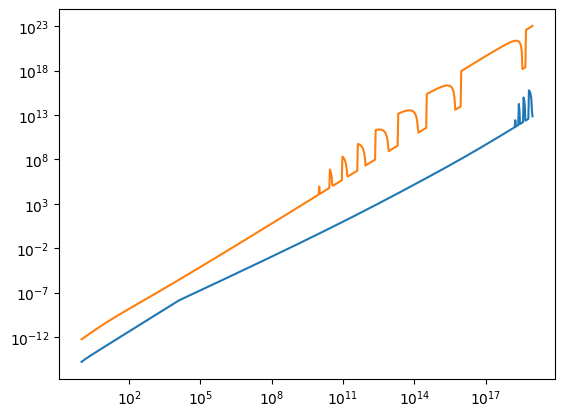

In [100]:
plt.plot(mass_range, annihilation_rates[0])
plt.plot(mass_range, annihilation_rates[-1])
plt.xscale('log')
plt.yscale('log')

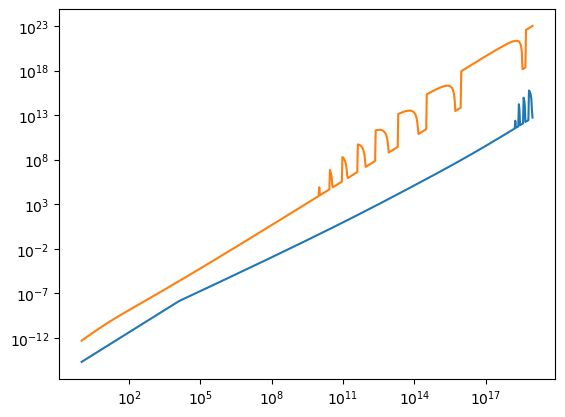

In [ ]:
plt.plot(mass_range, annihilation_rates[0])
plt.plot(mass_range, annihilation_rates[-1])
plt.xscale('log')
plt.yscale('log')